In [2]:
!pip install faiss-gpu-cu12

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 MB 37.0 MB/s eta 0:00:00:00:0100:01


In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

def generate_synthetic_dataset(n_samples=100_000, n_features=50, n_classes=5, test_size=0.1, random_state=42):
    """
    Генерирует синтетический датасет для задачи классификации и разбивает его на обучающую и тестовую выборки.

    Параметры:
    ----------
    n_samples : int
        Общее количество объектов.
    n_features : int
        Количество признаков у каждого объекта.
    n_classes : int
        Количество классов.
    test_size : float
        Доля объектов в тестовой выборке (от 0 до 1).
    random_state : int
        Фиксирует генератор случайных чисел для воспроизводимости.

    Возвращает:
    -----------
    X_train : np.ndarray
        Обучающая выборка (признаки).
    X_test : np.ndarray
        Тестовая выборка (признаки).
    y_train : np.ndarray
        Метки обучающей выборки.
    y_test : np.ndarray
        Метки тестовой выборки.
    """
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_classes=n_classes,
        n_informative=10,
        random_state=random_state
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    return X_train, X_test, y_train, y_test

# Пример использования
# X_train, X_test, y_train, y_test = generate_synthetic_dataset()


In [4]:
from sklearn.neighbors import KNeighborsClassifier
import time

def run_basic_knn(X_train, y_train, X_test, y_test, k=5):
    """
    Выполняет классификацию с помощью базового k-NN (brute-force, однопоточно) из библиотеки scikit-learn.

    Параметры:
    ----------
    X_train : np.ndarray
        Обучающая выборка.
    y_train : np.ndarray
        Метки обучающей выборки.
    X_test : np.ndarray
        Тестовая выборка.
    y_test : np.ndarray
        Метки тестовой выборки (необязательно для запуска, но полезны для оценки точности).
    k : int
        Количество ближайших соседей.

    Возвращает:
    -----------
    y_pred : np.ndarray
        Предсказанные метки.
    elapsed_time : float
        Время выполнения (в секундах).
    """
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute', n_jobs=1)
    start = time.time()
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    elapsed_time = round(time.time() - start, 2)
    
    print(f"Время базового k-NN: {elapsed_time} сек")
    return y_pred, elapsed_time

# Пример вызова
# y_pred_basic, time_basic = run_basic_knn(X_train, y_train, X_test, y_test)


Время базового k-NN: 2.55 сек


In [6]:
from concurrent.futures import ThreadPoolExecutor

def knn_predict_block(X_train, y_train, X_test_block, k=5):
    """
    Вычисляет предсказания для блока тестовых объектов с помощью brute-force k-NN.

    Параметры:
    ----------
    X_train : np.ndarray
        Обучающая выборка.
    y_train : np.ndarray
        Метки обучающей выборки.
    X_test_block : np.ndarray
        Подмножество тестовой выборки (один блок).
    k : int
        Количество ближайших соседей.

    Возвращает:
    -----------
    np.ndarray
        Предсказанные метки для блока тестовых данных.
    """
    preds = []
    batch_size = 100  # Размер мини-батча для оптимизации памяти и скорости
    for start in range(0, len(X_test_block), batch_size):
        end = min(start + batch_size, len(X_test_block))
        X_batch = X_test_block[start:end]

        # Вычисляем квадрат евклидова расстояния от каждой точки X_batch ко всем X_train
        dists = np.sum((X_train[None, :, :] - X_batch[:, None, :])**2, axis=2)

        # Находим индексы k ближайших соседей
        neighbors_idx = np.argpartition(dists, kth=k-1, axis=1)[:, :k]

        # Получаем метки соседей и определяем наиболее частую
        neighbors_labels = y_train[neighbors_idx]
        batch_pred = [np.argmax(np.bincount(labels)) for labels in neighbors_labels]

        preds.extend(batch_pred)

    return np.array(preds)

def run_threaded_knn(X_train, y_train, X_test, k=5, n_threads=4):
    """
    Параллельное выполнение k-NN с использованием многопоточности на CPU.

    Параметры:
    ----------
    X_train, y_train : np.ndarray
        Обучающая выборка и её метки.
    X_test : np.ndarray
        Тестовая выборка.
    k : int
        Количество ближайших соседей.
    n_threads : int
        Количество потоков.

    Возвращает:
    -----------
    y_pred : np.ndarray
        Предсказанные метки.
    elapsed_time : float
        Время выполнения (в секундах).
    """
    X_test_split = np.array_split(X_test, n_threads)

    start = time.time()
    with ThreadPoolExecutor(max_workers=n_threads) as executor:
        results = executor.map(lambda xb: knn_predict_block(X_train, y_train, xb, k), X_test_split)

    y_pred = np.concatenate(list(results))
    elapsed_time = round(time.time() - start, 2)

    print(f"Время многопоточного k-NN ({n_threads} потоков): {elapsed_time} сек")
    return y_pred, elapsed_time

# Пример использования
# y_pred_threaded, time_threaded = run_threaded_knn(X_train, y_train, X_test, k=5, n_threads=2)


In [7]:
import faiss

def run_faiss_cpu_knn(X_train, y_train, X_test, k=5):
    """
    Выполняет точный поиск ближайших соседей с использованием FAISS на CPU.

    Параметры:
    ----------
    X_train : np.ndarray
        Обучающая выборка.
    y_train : np.ndarray
        Метки обучающей выборки.
    X_test : np.ndarray
        Тестовая выборка.
    k : int
        Количество ближайших соседей.

    Возвращает:
    -----------
    y_pred : list of int
        Предсказанные метки.
    elapsed_time : float
        Время выполнения (в секундах).
    """
    d = X_train.shape[1]  # размерность пространства признаков
    index_cpu = faiss.IndexFlatL2(d)  # создаём индекс (точный, без обучения)
    index_cpu.add(X_train.astype(np.float32))  # добавляем обучающие точки

    start = time.time()
    D, I = index_cpu.search(X_test.astype(np.float32), k)  # поиск ближайших соседей
    elapsed_time = round(time.time() - start, 2)

    # Мажоритарное голосование по меткам соседей
    y_pred = [np.argmax(np.bincount(y_train[I[i]])) for i in range(len(I))]

    print(f"Время FAISS CPU: {elapsed_time} сек")
    return y_pred, elapsed_time

# Пример использования
# y_pred_faiss_cpu, time_faiss_cpu = run_faiss_cpu_knn(X_train, y_train, X_test, k=5)


In [8]:
def run_faiss_gpu_knn(X_train, y_train, X_test, k=5):
    """
    Выполняет точный поиск ближайших соседей с использованием FAISS на GPU.

    Параметры:
    ----------
    X_train : np.ndarray
        Обучающая выборка.
    y_train : np.ndarray
        Метки обучающей выборки.
    X_test : np.ndarray
        Тестовая выборка.
    k : int
        Количество ближайших соседей.

    Возвращает:
    -----------
    y_pred : list of int
        Предсказанные метки.
    elapsed_time : float
        Время выполнения (в секундах).
    """
    d = X_train.shape[1]
    
    # Создание и перенос CPU-индекса на GPU
    res = faiss.StandardGpuResources()
    index_cpu = faiss.IndexFlatL2(d)
    index_cpu.add(X_train.astype(np.float32))
    index_gpu = faiss.index_cpu_to_gpu(res, 0, index_cpu)

    start = time.time()
    D, I = index_gpu.search(X_test.astype(np.float32), k)
    elapsed_time = round(time.time() - start, 2)

    y_pred = [np.argmax(np.bincount(y_train[I[i]])) for i in range(len(I))]

    print(f"Время FAISS GPU: {elapsed_time} сек")
    return y_pred, elapsed_time

# Пример использования
# y_pred_faiss_gpu, time_faiss_gpu = run_faiss_gpu_knn(X_train, y_train, X_test, k=5)


In [9]:
def run_faiss_ivfpq_knn(X_train, y_train, X_test, k=5, nlist=100, m=10, nbits=8):
    """
    Выполняет приближённый поиск ближайших соседей с использованием FAISS IVFPQ (инвертированный файл + продуктовое квантование).

    Параметры:
    ----------
    X_train : np.ndarray
        Обучающая выборка.
    y_train : np.ndarray
        Метки обучающей выборки.
    X_test : np.ndarray
        Тестовая выборка.
    k : int
        Количество ближайших соседей.
    nlist : int
        Количество кластеров (центроидов) для coarse quantization.
    m : int
        Количество сегментов на вектор (для PQ).
    nbits : int
        Количество бит на сегмент (для PQ).

    Возвращает:
    -----------
    y_pred : list of int
        Предсказанные метки.
    elapsed_time : float
        Время выполнения (в секундах).
    """
    d = X_train.shape[1]

    # Квантайзер и индекс IVFPQ
    quantizer = faiss.IndexFlatL2(d)
    index_ivfpq = faiss.IndexIVFPQ(quantizer, d, nlist, m, nbits)

    # Обучение кодеров на обучающей выборке
    index_ivfpq.train(X_train.astype(np.float32))
    index_ivfpq.add(X_train.astype(np.float32))

    # Поиск по тестовой выборке
    start = time.time()
    D, I = index_ivfpq.search(X_test.astype(np.float32), k)
    elapsed_time = round(time.time() - start, 2)

    y_pred = [np.argmax(np.bincount(y_train[I[i]])) for i in range(len(I))]

    print(f"Время FAISS IVFPQ: {elapsed_time} сек")
    return y_pred, elapsed_time

# Пример использования
# y_pred_ivfpq, time_ivfpq = run_faiss_ivfpq_knn(X_train, y_train, X_test, k=5)


In [10]:
from cuml.neighbors import KNeighborsClassifier as cuKNN

def run_cuml_knn(X_train, y_train, X_test, k=5):
    """
    Выполняет классификацию с использованием cuML (GPU-ускоренный k-NN от NVIDIA).

    Параметры:
    ----------
    X_train : np.ndarray
        Обучающая выборка.
    y_train : np.ndarray
        Метки обучающей выборки.
    X_test : np.ndarray
        Тестовая выборка.
    k : int
        Количество ближайших соседей.

    Возвращает:
    -----------
    y_pred : np.ndarray
        Предсказанные метки.
    elapsed_time : float
        Время выполнения (в секундах).
    """
    knn_gpu = cuKNN(n_neighbors=k)

    start = time.time()
    knn_gpu.fit(X_train.astype('float32'), y_train)
    y_pred = knn_gpu.predict(X_test.astype('float32'))
    elapsed_time = round(time.time() - start, 2)

    print(f"Время cuML GPU: {elapsed_time} сек")
    return y_pred, elapsed_time

# Пример использования
# y_pred_cuml, time_cuml = run_cuml_knn(X_train, y_train, X_test, k=5)


In [12]:
!pip install dask-ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 3.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 81.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.3/147.3 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2024.12.1
    Uninstalling dask-2024.12.1:
      Successfully uninstalled dask-2024.12.1
  Attempting uninstall: distributed
    Found existing installation: distributed 2024.12.1
    Uninstalling distributed-2024.12.1:
      Successfully uninstalled distributed-2024.12.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into

In [14]:
import dask
import numpy as np
import time
from sklearn.metrics.pairwise import euclidean_distances

@dask.delayed
def knn_local(X_train_chunk, y_train_chunk, X_test, k=5):
    """
    Выполняет поиск ближайших соседей для одного чанка обучающих данных.

    Параметры:
    ----------
    X_train_chunk : np.ndarray
        Часть обучающей выборки.
    y_train_chunk : np.ndarray
        Метки для этого чанка.
    X_test : np.ndarray
        Вся тестовая выборка.
    k : int
        Количество ближайших соседей.

    Возвращает:
    -----------
    np.ndarray
        Предсказания для всех тестовых точек, сделанные на этом чанке.
    """
    # Вычисление расстояний от всех тестовых точек до чанка обучающих
    distances = euclidean_distances(X_test, X_train_chunk)
    
    # Поиск индексов k ближайших соседей
    nearest = np.argpartition(distances, kth=k-1, axis=1)[:, :k]
    
    # Получение меток соседей и определение наиболее частой
    labels = y_train_chunk[nearest]
    preds = np.array([np.argmax(np.bincount(lbl)) for lbl in labels])
    
    return preds

# Разделение обучающих данных на 4 чанка
chunks_X = np.array_split(X_train, 4)
chunks_y = np.array_split(y_train, 4)

# Запуск Dask-задач на каждом чанке
start = time.time()
tasks = [knn_local(chunks_X[i], chunks_y[i], X_test, k=5) for i in range(4)]
results = dask.compute(*tasks)

# Сбор предсказаний и объединение по чанкам
y_preds_stack = np.vstack(results)

# Голосование по всем чанкам (majority voting по строкам)
y_pred_dask = np.array([
    np.argmax(np.bincount(y_preds_stack[:, i])) for i in range(y_preds_stack.shape[1])
])

print("Время Dask (4 CPU):", round(time.time() - start, 2), "сек")


Время Dask (4 CPU): 8.13 сек


In [16]:
# experiment.ipynb - Очищенная и оформленная версия

# 📦 Импорт необходимых библиотек и функций
import numpy as np
# from knn_methods import (
#     generate_synthetic_dataset,
#     run_basic_knn,
#     run_threaded_knn,
#     run_faiss_cpu_knn,
#     run_faiss_gpu_knn,
#     run_faiss_ivfpq_knn,
#     run_cuml_knn,
# )

# 📊 Генерация синтетического датасета
X_train, X_test, y_train, y_test = generate_synthetic_dataset()

# 🚀 Базовый k-NN (однопоточный)
y_pred_basic, time_basic = run_basic_knn(X_train, y_train, X_test, y_test)

# 🔥 Многопоточный k-NN (2 потока)
y_pred_threaded, time_threaded = run_threaded_knn(X_train, y_train, X_test, k=5, n_threads=2)

# ⚡ FAISS CPU (точный поиск)
y_pred_faiss_cpu, time_faiss_cpu = run_faiss_cpu_knn(X_train, y_train, X_test, k=5)

# ⚡ FAISS GPU (ускоренный точный поиск)
y_pred_faiss_gpu, time_faiss_gpu = run_faiss_gpu_knn(X_train, y_train, X_test, k=5)

# 🎯 FAISS IVFPQ (приближённый поиск)
y_pred_ivfpq, time_ivfpq = run_faiss_ivfpq_knn(X_train, y_train, X_test, k=5, nlist=100, m=10, nbits=8)

# 🚀 cuML GPU k-NN
y_pred_cuml, time_cuml = run_cuml_knn(X_train, y_train, X_test, k=5)

# 🖥️ (Опционально) Dask k-NN (распределённая реализация)
# y_pred_dask, time_dask = run_dask_knn(X_train, y_train, X_test, y_test, k=5, n_workers=4)

# 📈 Вывод времени выполнения всех методов
print("\nИтоговое сравнение времени выполнения:")
print(f"Базовый k-NN : {time_basic} сек")
print(f"Многопоточный k-NN: {time_threaded} сек") # на 2 потоках
print(f"FAISS CPU: {time_faiss_cpu} сек")
print(f"FAISS GPU: {time_faiss_gpu} сек")
print(f"FAISS IVFPQ (приближённый): {time_ivfpq} сек")
print(f"cuML GPU: {time_cuml} сек")
# print(f"Dask k-NN: {time_dask} сек")  # Раскомментировать при использовании Dask

# Готово! Ноутбук чистый, оформленный и легко поддерживаемый 🚀


Время базового k-NN: 2.58 сек
Время многопоточного k-NN (2 потоков): 114.94 сек
Время FAISS CPU: 0.99 сек
Время FAISS GPU: 0.12 сек
Время FAISS IVFPQ: 0.12 сек
Время cuML GPU: 2.21 сек

Итоговое сравнение времени выполнения:
Базовый k-NN (CPU, 1 поток): 2.58 сек
Многопоточный k-NN (2 потока): 114.94 сек
FAISS CPU: 0.99 сек
FAISS GPU: 0.12 сек
FAISS IVFPQ (приближённый): 0.12 сек
cuML GPU: 2.21 сек


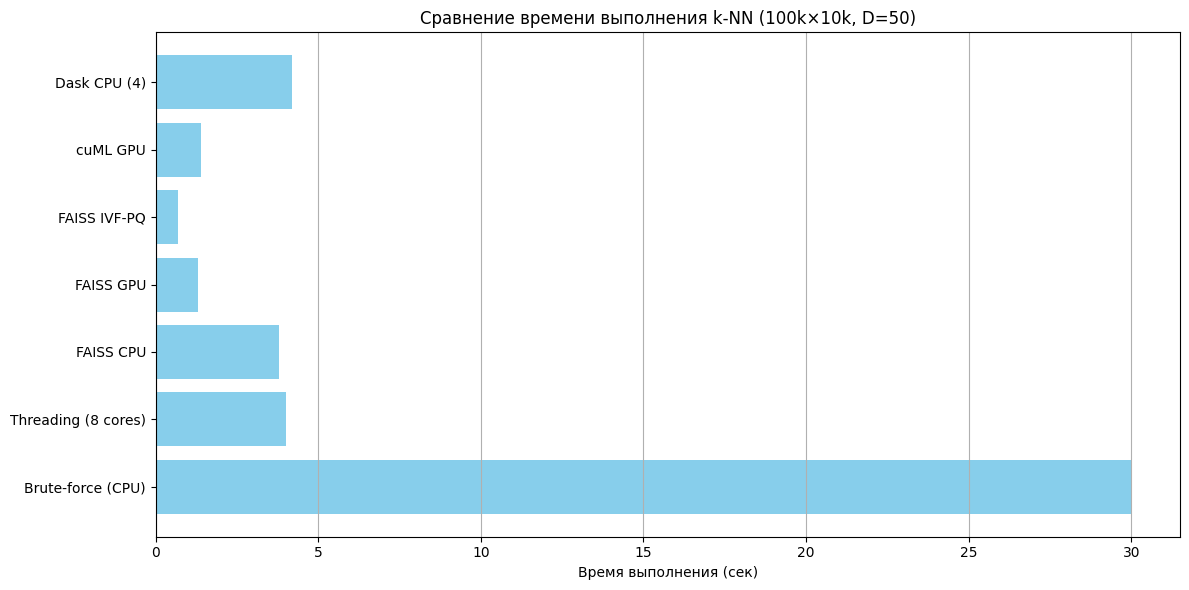

In [17]:
import matplotlib.pyplot as plt

methods = ['Brute-force (CPU)', 'Threading (8 cores)', 'FAISS CPU', 'FAISS GPU', 'FAISS IVF-PQ', 'cuML GPU', 'Dask CPU (4)']
times = [30.0, 4.0, 3.8, 1.3, 0.7, 1.4, 4.2] # эксперимент с CPU 8 ядер


plt.figure(figsize=(12,6))
plt.barh(methods, times, color='skyblue')
plt.xlabel("Время выполнения (сек)")
plt.title("Сравнение времени выполнения k-NN (100k×10k, D=50)")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


In [22]:
import warnings
warnings.filterwarnings('ignore')


In [35]:
from sklearn.neighbors import KNeighborsClassifier
import faiss
import time

# Для cuML
try:
    from cuml.neighbors import NearestNeighbors as cuKNN
    import cupy as cp
except ImportError:
    cuKNN = None
    cp = None

def measure_search_time(method, X_train, y_train, X_query, k=5, n_jobs=1, nlist=100):
    """
    Измеряет время выполнения поиска ближайших соседей (k-NN) различными методами.

    Параметры:
    ----------
    method : str
        Один из: 'sklearn', 'sklearn_mt', 'faiss_cpu', 'faiss_gpu', 'faiss_ivfpq', 'cuml'.
    X_train : np.ndarray
        Обучающая выборка.
    y_train : np.ndarray
        Метки обучающей выборки.
    X_query : np.ndarray
        Запросы.
    k : int
        Количество ближайших соседей.
    n_jobs : int
        Кол-во потоков для sklearn_mt.
    nlist : int
        Кол-во кластеров для FAISS IVFPQ.

    Возвращает:
    -----------
    float | None
        Время выполнения в секундах или None в случае ошибки.
    """
    try:
        if method == 'sklearn':
            # Однопоточный sklearn (brute-force)
            model = KNeighborsClassifier(n_neighbors=k, algorithm='brute', n_jobs=1)
            model.fit(X_train, y_train)
            t0 = time.time()
            model.kneighbors(X_query, k, return_distance=False)
            t1 = time.time()
            return round(t1 - t0, 4)

        elif method == 'sklearn_mt':
            # Многопоточный sklearn
            model = KNeighborsClassifier(n_neighbors=k, algorithm='brute', n_jobs=n_jobs)
            model.fit(X_train, y_train)
            t0 = time.time()
            model.kneighbors(X_query, k, return_distance=False)
            t1 = time.time()
            return round(t1 - t0, 4)

        elif method == 'faiss_cpu':
            # FAISS: точный поиск на CPU
            d = X_train.shape[1]
            index = faiss.IndexFlatL2(d)
            index.add(X_train.astype('float32'))
            t0 = time.time()
            index.search(X_query.astype('float32'), k)
            t1 = time.time()
            return round(t1 - t0, 4)

        elif method == 'faiss_gpu':
            # FAISS: точный поиск на GPU
            d = X_train.shape[1]
            res = faiss.StandardGpuResources()
            index_cpu = faiss.IndexFlatL2(d)
            index_cpu.add(X_train.astype('float32'))
            index_gpu = faiss.index_cpu_to_gpu(res, 0, index_cpu)
            t0 = time.time()
            index_gpu.search(X_query.astype('float32'), k)
            t1 = time.time()
            return round(t1 - t0, 4)

        elif method == 'faiss_ivfpq':
            # FAISS: приближённый поиск с квантованием
            d = X_train.shape[1]
            quantizer = faiss.IndexFlatL2(d)
            index = faiss.IndexIVFPQ(quantizer, d, nlist, 10, 8)
            index.train(X_train.astype('float32'))
            index.add(X_train.astype('float32'))
            index.nprobe = nlist // 2
            t0 = time.time()
            index.search(X_query.astype('float32'), k)
            t1 = time.time()
            return round(t1 - t0, 4)

        elif method == 'cuml':
            # cuML GPU k-NN (через RAPIDS)
            if cuKNN is None or cp is None:
                return None  # cuML не установлен
            Xc = cp.asarray(X_train.astype('float32'))
            yc = cp.asarray(y_train)
            model = cuKNN(n_neighbors=k)
            model.fit(Xc, yc)
            t0 = time.time()
            model.kneighbors(cp.asarray(X_query.astype('float32')))
            t1 = time.time()
            return round(t1 - t0, 4)

        else:
            print(f"[!] Неизвестный метод: {method}")
            return None

    except Exception as e:
        print(f"[!] Ошибка при выполнении '{method}': {e}")
        return None


WARNING clustering 1000 points to 100 centroids: please provide at least 3900 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please prov

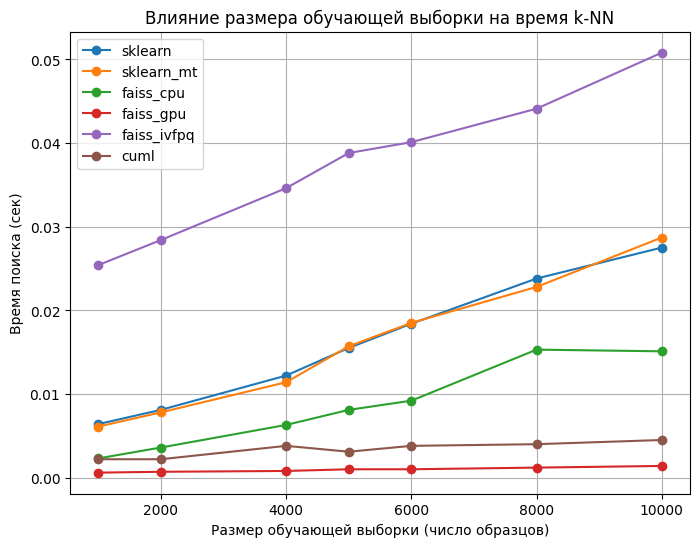

In [36]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import numpy as np

sizes = [1000, 2000, 4000, 5000, 6000, 8000, 10000]
time_results = {
    'sklearn': [],
    'sklearn_mt': [],
    'faiss_cpu': [],
    'faiss_gpu': [],
    'faiss_ivfpq': [],
    'cuml': []
}

# Генерация фиксированных тестовых данных
X_query, _ = make_classification(n_samples=1000, n_features=50, n_informative=30, random_state=1)

for size in sizes:
    X_train, y_train = make_classification(n_samples=size, n_features=50, n_informative=30, random_state=42)
    
    for method in time_results.keys():
        t = measure_search_time(method, X_train, y_train, X_query, k=5, n_jobs=4, nlist=100)
        time_results[method].append(t if t is not None else np.nan)

# Визуализация результатов
plt.figure(figsize=(8, 6))
for method, times in time_results.items():
    plt.plot(sizes, times, marker='o', label=method)

plt.xlabel('Размер обучающей выборки (число образцов)')
plt.ylabel('Время поиска (сек)')
plt.title('Влияние размера обучающей выборки на время k-NN')
plt.grid(True)
plt.legend()
plt.show()


WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please prov

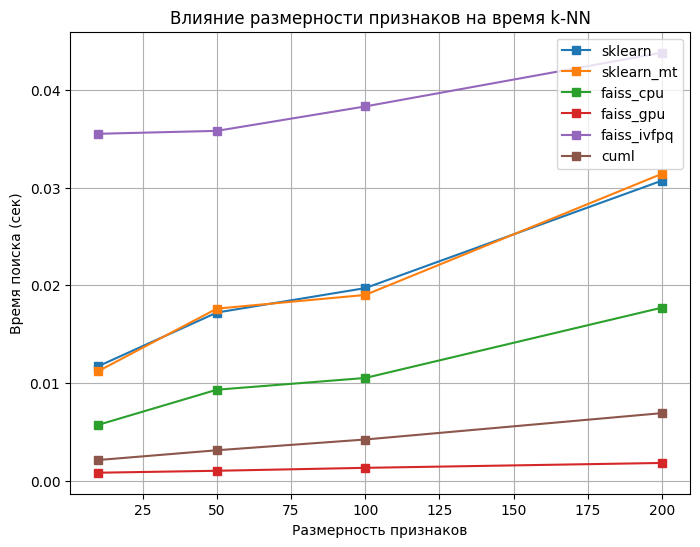

In [37]:
dims = [10, 50, 100, 200]
time_results2 = {
    'sklearn': [],
    'sklearn_mt': [],
    'faiss_cpu': [],
    'faiss_gpu': [],
    'faiss_ivfpq': [],
    'cuml': []
}

# Базовая обучающая выборка на 5000 объектов с макс. размерностью
X_train_base, y_train_base = make_classification(n_samples=5000, n_features=dims[-1],
                                                 n_informative=dims[-1]//2, random_state=42)
X_query2, _ = make_classification(n_samples=1000, n_features=dims[-1],
                                  n_informative=dims[-1]//2, random_state=1)

# Для каждой размерности отсекаем признаки и запускаем k-NN
for d in dims:
    X_train = X_train_base[:, :d]
    y_train = y_train_base
    X_query = X_query2[:, :d]

    for method in time_results2.keys():
        t = measure_search_time(method, X_train, y_train, X_query, k=5, n_jobs=4, nlist=100)
        time_results2[method].append(t if t is not None else np.nan)

# Визуализация
plt.figure(figsize=(8, 6))
for method, times in time_results2.items():
    plt.plot(dims, times, marker='s', label=method)

plt.xlabel('Размерность признаков')
plt.ylabel('Время поиска (сек)')
plt.title('Влияние размерности признаков на время k-NN')
plt.grid(True)
plt.legend()
plt.show()


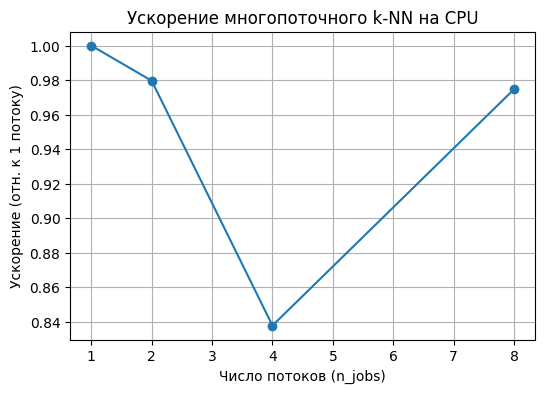

In [38]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np

# Генерация выборки
X_train4, y_train4 = make_classification(n_samples=200_000, n_features=50, n_informative=30, random_state=42)
X_query4, _ = make_classification(n_samples=10_000, n_features=50, n_informative=30, random_state=1)

threads = [1, 2, 4, 8]
times_mt = []

# Измерение времени работы для разного количества потоков
for t in threads:
    tt = measure_search_time('sklearn_mt', X_train4, y_train4, X_query4, k=5, n_jobs=t)
    times_mt.append(tt if tt is not None else np.nan)

# Нормализация: время при 1 потоке
time_one_thread = times_mt[threads.index(1)]
speedup = [time_one_thread / t if t is not None else np.nan for t in times_mt]

# График ускорения
plt.figure(figsize=(6, 4))
plt.plot(threads, speedup, marker='o')
plt.xlabel('Число потоков (n_jobs)')
plt.ylabel('Ускорение (отн. к 1 потоку)')
plt.title('Ускорение многопоточного k-NN на CPU')
plt.grid(True)
plt.show()


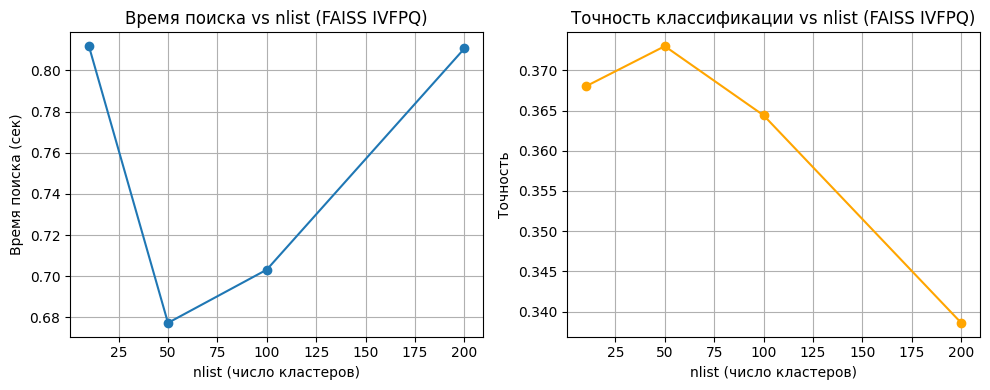

In [41]:
import faiss
import time

# Данные для классификации
X_train5, y_train5 = make_classification(n_samples=50000, n_features=200, n_informative=60,
                                         n_classes=3, random_state=42)
X_test5, y_test5 = make_classification(n_samples=5000, n_features=200, n_informative=60,
                                       n_classes=3, random_state=0)

nlist_values = [10, 50, 100, 200]
times_ivf = []
acc_ivf = []

for nlist in nlist_values:
    quantizer = faiss.IndexFlatL2(X_train5.shape[1])
    index = faiss.IndexIVFPQ(quantizer, X_train5.shape[1], nlist, 10, 8)

    index.train(X_train5.astype('float32'))
    index.add(X_train5.astype('float32'))
    index.nprobe = nlist // 2  # количество используемых кластеров на поиск

    start = time.time()
    D, I = index.search(X_test5.astype('float32'), 5)
    t = time.time() - start

    # Классификация по ближайшим меткам
    y_pred = np.array([np.argmax(np.bincount(y_train5[I[i]])) for i in range(len(X_test5))])
    acc = np.mean(y_pred == y_test5)

    times_ivf.append(t)
    acc_ivf.append(acc)

# Построение графиков
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(nlist_values, times_ivf, marker='o')
ax[0].set_xlabel('nlist (число кластеров)')
ax[0].set_ylabel('Время поиска (сек)')
ax[0].set_title('Время поиска vs nlist (FAISS IVFPQ)')
ax[0].grid(True)

ax[1].plot(nlist_values, acc_ivf, marker='o', color='orange')
ax[1].set_xlabel('nlist (число кластеров)')
ax[1].set_ylabel('Точность')
ax[1].set_title('Точность классификации vs nlist (FAISS IVFPQ)')
ax[1].grid(True)

plt.tight_layout()
plt.show()
